In [1]:
## ---{ BIBLIOTHEQUES }--- ##
#%pip install tensorflow
#%pip install scipy

import time #Chronomètre
import os, sys, shutil #Fonctions systèmes (Windows/Linux/Mac)
import random #Fonction aléatoire
import matplotlib.pyplot as plt  #Affichage human-friendly
#import mysql.connector #Gestion d'une base de données MySQL
import traceback #Rendre les exceptions plus human-readable
import pandas as pd #Sauvegarde .csv (~excel)
import numpy as np #Manipulation de matrices
from datetime import datetime #Obtention de l'heure 

## ---{ BIBLIOTHEQUE DE DEEP LEARNING }--- ##

# Front end = KERAS (~fonctions manipulables par l'être humain)
# Back end = TENSORFLOW (~calcul mathématique caché)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array

2023-01-19 10:51:17.220403: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
## ---{ VARIABLES GLOBALES }--- ##

# { --->
classes = ['0_AUTRES','1_EUDEMIS']
libelle = "Test_5_epochs_5_limite_SDA"
# <--- }

In [3]:
## ---{ VARIABLES GLOBALES }--- ##

nb_classes  = len(classes)
id=libelle
ROOT_FOLDER=r"/Users/schaeferphilip/Documents/Bihar/AI4industry" #Répertoire de travail de l'utilisateur
FOLDER_IN  = "/Users/schaeferphilip/Documents/Bihar/AI4industry/VIGNETTES" #Stockage d'origine des vignettes utilisés
FOLDER_OUT = ROOT_FOLDER+"/FOLDER_OUT" #Stockage temporaire des vignettes utilisés
FOLDER_SAVE = ROOT_FOLDER+"/"+libelle #Stockage des fichiers générés par l'entraînement
VIGNETTES_LABELS=r"/Users/schaeferphilip/Documents/Bihar/AI4industry/VIGNETTES_LABELS.csv"

if os.path.exists(FOLDER_SAVE) == False:
    os.makedirs(FOLDER_SAVE)
FOLDER_SAVE_VP = FOLDER_SAVE+"/VP"+libelle #Stockage des VP
FOLDER_SAVE_FP = FOLDER_SAVE+"/FP"+libelle #Stockage des FP

for classe_i in classes:
    if os.path.exists(FOLDER_SAVE_VP+"/"+classe_i) == True:
        os.rmdir(FOLDER_SAVE_VP+"/"+classe_i)
    if os.path.exists(FOLDER_SAVE_FP+"/"+classe_i) == True:
        os.rmdir(FOLDER_SAVE_FP+"/"+classe_i)
    os.makedirs(FOLDER_SAVE_VP+"/"+classe_i)
    os.makedirs(FOLDER_SAVE_FP+"/"+classe_i)

In [4]:
## ---{ VARIABLES GLOBALES }--- ##
# Modification possible : définition des paramètres généraux de l'entraînement

# { --->
nb_epochs   = 5 #Nombre d'epochs = la durée et la complexité de l'entraînement (dépend des effectifs de chaque classe)
ratio       = 0.3 #Part d'images gardés en validation : la séparation se fait aléatoirement
FLAG_DA     = 0 #Flag d'activation de la data-augmentation 'sur le vif' (les vignettes sont randomisées avant chaque epoch)
# <--- }

coef        = 0 #Coefficient multiplicateur de la data-augmentation 'en dur' (plus utilisé mais toujours possible)
iterations  = 1 #Nombre de répétitions de l'entrainement (2-3 conseillées pour confirmer la tendance) #Inutile ds jupyter-notebook
#Méthode de limitation des vignettes utilisées pour l'entrainement. Tout le reste ira en validation.
effectifs_entrainement = [0 for i in range(nb_classes)] # 0 = pas de limitation
effectifs_entrainement = [0,400] # Limitation des effectifs de chaque classe

In [5]:
## ---{ VARIABLES GLOBALES }--- ##
# NE PAS TOUCHER !

if coef == 1:
    coef == 0
    
#Fichiers.txt pour récupérer rapidement les résultats et les erreurs
file_1 = open(FOLDER_SAVE+"/Suivi_"+id+".txt", 'w+')
file_1.write("%s : %s (%s)\nratio = %s, coef = %s, FLAG_DA = %s, iterations = %s, nb_epochs = %s\n" % (id, classes, nb_classes, ratio, coef, FLAG_DA, iterations, nb_epochs))
file_1.close
file_2 = open(FOLDER_SAVE+"/Erreurs_"+id+".txt",'w+')
file_2.write("nom_fichier_vignette,classe_predite,valeur_classe_predite,classe_reel,valeur_classe_reel\n")
file_2.close

<function TextIOWrapper.close()>

In [6]:
## ---{ VARIABLES GLOBALES }--- ##
# Modification possible mais paramètres déjà optimaux : data-augmentation

# { --->
rotation_range     = 90 #Amplitude rotation
width_shift_range  = 0.1 #Amplitude translation
height_shift_range = 0.1 #Amplitude translation
shear_range        = 10 #Amplitude déformation
horizontal_flip    = True #Miroir
vertical_flip      = True #Miroir
# <--- }

In [7]:
### Obtention tableau nom_fichier_vignette ###

#Création du dictionnaire de vignettes
dictionnaire = [[] for i in range(nb_classes)]

with open(VIGNETTES_LABELS) as f:
    next(f)
    for line in f:
        data=line.split(',')
        labels=data[0].split(';')
        if labels.count('26')!=0: #Cas EUDEMIS
            dictionnaire[1].append([data[1],labels,data[2:]])
        else: #Cas AUTRES
            dictionnaire[0].append([data[1],labels,data[2:]])

print(dictionnaire[0][0:2])
print(dictionnaire[1][0:2])

[['202_d-2021-07-02_tr_n-000_h-231513;2381;2498;561;593;V0.png', ['5', '7'], ['d4be4d17d9c8eba8beeee7069528b278', '2662', '117.003', '31.6561', '3.69605', '0.0618967', '0.718712', '280.995', '9.47348', '0.423663', '7.78451', '86.5999', '67.8035', '134.387', '533.198', '480.783', '25', '167', '71.6389', '448.503\n']], ['202_d-2021-07-25_tr_n-000_h-230502;2102;2134;1133;1209;V0.png', ['5', '7'], ['6f1177a62250e24e2dea37e0acfd9815', '1119.5', '78.9443', '19.26', '4.09887', '0.0571785', '0.736287', '188.752', '5.93105', '0.394866', '29.791', '114.972', '95.4521', '122.896', '579.361', '343.26', '60', '164', '98.9542', '383.036\n']]]
[['07__sVT_869170031917314_Pictures_207_2021-05-10_23_207_d-2021-05-10_trCP_n-000_h-230341;1398;1456;730;767;V0.png', ['26'], ['d50b808c883b940fd207e5ef06d24a45', '1294.5', '63.5814', '29.1447', '2.18158', '0.101928', '0.698575', '165.095', '7.84092', '0.596818', '65.833', '127.722', '114.641', '24.8527', '303.901', '205.835', '87', '162', '116.292', '208.976\n

In [8]:
### Récupération des vignettes : séparation train/test ###
print("--> Séparation train/test")

buffer_train = [[x for x in dictionnaire[j]] for j in range(nb_classes)]

#Suppression dossier de destination si pré-existant
if os.path.exists(FOLDER_OUT) == True:
    shutil.rmtree(FOLDER_OUT, ignore_errors = True)

for i in range(nb_classes):        
    #Création dossier train
    save_path_train = FOLDER_OUT+"/train/"+classes[i]
    if os.path.exists(save_path_train) == False:
        os.makedirs(save_path_train)    
    #Création dossier test
    save_path_test = FOLDER_OUT+"/test/"+classes[i]
    if os.path.exists(save_path_test) == False:
        os.makedirs(save_path_test)    

    buffer_test = []
    if effectifs_entrainement[i] == 0:
        #Sélection aléatoire des images test selon le ratio
        for j in range(round(ratio*len(buffer_train[i]))):
            a = random.choice(range(len(buffer_train[i])))
            buffer_test.append(buffer_train[i][a])
            buffer_train[i].remove(buffer_train[i][a])
    else:
        #Sélection aléatoire d'un nombre donné de vignettes
        while len(buffer_train[i])>effectifs_entrainement[i]:
            #a = random.choice(range(len(buffer_train[i])))
            for x in range(len(buffer_train[i])-effectifs_entrainement[i]):
                buffer_test.append(buffer_train[i][0])
                buffer_train[i].remove(buffer_train[i][0])

    #Les images sont alors copiées
    for j in range(len(buffer_test)):
        shutil.copyfile(FOLDER_IN+"/"+buffer_test[j][0], save_path_test+"/"+buffer_test[j][0])
    for j in range(len(buffer_train[i])):
        shutil.copyfile(FOLDER_IN+"/"+buffer_train[i][j][0], save_path_train+"/"+buffer_train[i][j][0])
print("Done")

--> Séparation train/test
Done


In [9]:
### Data-augmentation 'en dur' avant entraînement ###

if coef > 1:
    print("--> Data-augmentation 'en dur'")

    #Définition des transformations aléatoires appliquées à la vignette
    datagen = ImageDataGenerator(
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        shear_range=shear_range,
        horizontal_flip=horizontal_flip,
        vertical_flip=vertical_flip)

    for i in range(nb_classes):
        #Récupération du chemin des vignettes
        save_path_train = FOLDER_OUT+"\\train\\"+classes[i]
        vignettes = os.listdir(save_path_train)
        vignettes = [save_path_train+"\\"+vignettes[i] for i in range(len(vignettes))]

        for j in range(len(vignettes)):
            x = plt.imread(vignettes[j])
            x = x.reshape((1,)+x.shape)
            k = 1
            #Création de vignettes
            for batch in datagen.flow(x, batch_size=1, save_prefix=str(j), save_to_dir=save_path_train):
                k+=1
                if k==coef:
                    break
print("Done")

Done


--> Entraînement MobileNet : 2 classes ['0_AUTRES', '1_EUDEMIS']


2023-01-19 10:51:32.045882: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 4294 images belonging to 2 classes.
Found 2182 images belonging to 2 classes.


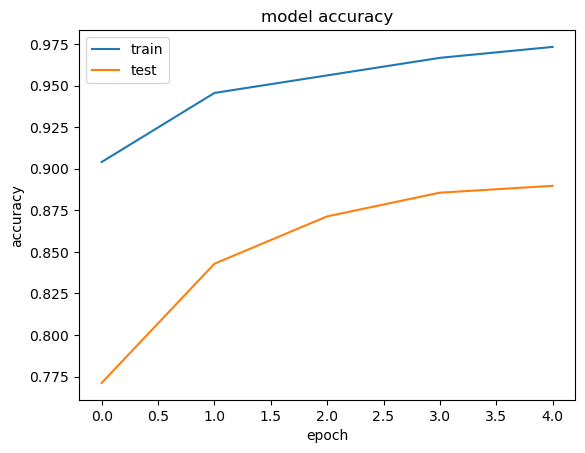

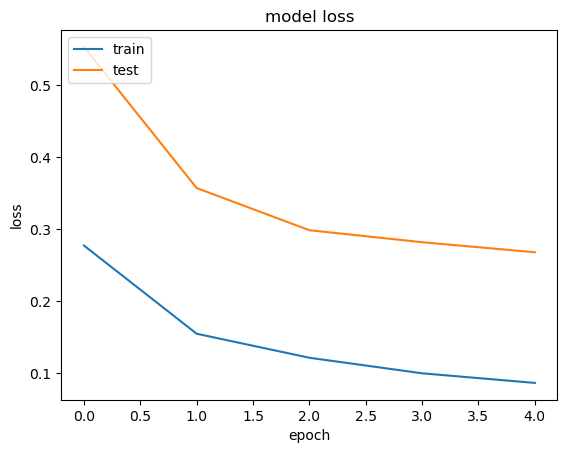

In [10]:
### ENTRAINEMENT ### 
print("--> Entraînement MobileNet : %s classes %s" % (nb_classes, classes))
# time_beginning=time.time()

#Définition du modèle
model     = MobileNet(weights='imagenet', include_top=False, input_shape=(128,128,3)) #Modification possible pour test (mais il faut fixer MobileNetV1 car c'est celui qu'on utilisera ds le dispo) : MobileNetV2(), MobileNetV3Small(), MobileNetV3Large()
x         = model.output
x         = GlobalAveragePooling2D()(x) #Modification possible : GlobalMaxPooling2D()
x         = Dense(1024,activation='relu')(x) #Modification possible : ajout de couches Dense(), modification de la fonction d'activation
sortie    = Dense(nb_classes, activation='softmax')(x)
mobilenet = Model(inputs=model.input, outputs=sortie)
del model, x, sortie

#Pré-processing des vignettes = data-augmentation 'sur le vif' avant chaque epoch
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
if FLAG_DA == 0:
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
else:
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        shear_range=shear_range,
        horizontal_flip=horizontal_flip,
        vertical_flip=vertical_flip)

#Création des batchs d'entraînement et de validation
train_generator = train_datagen.flow_from_directory(FOLDER_OUT+"/train", color_mode='rgb', batch_size=32, target_size=(128,128), class_mode='categorical', shuffle=True)
test_generator  = test_datagen.flow_from_directory(FOLDER_OUT+"/test", color_mode='rgb', batch_size=32, target_size=(128,128), class_mode='categorical', shuffle=False)

#Compilation du modèle
mobilenet.compile(loss='categorical_crossentropy',optimizer=SGD(learning_rate=1e-4, momentum=0.9),metrics=['accuracy'])  #Modification possible : Adagrad(), SGD(lr=1e-3)

#Création de points de sauvegarde
now             = datetime.now()
time            = now.strftime("%Y-%m-%d_%H%M%S")
best_loss       = "best_loss_"+str(id)+"("+time+").h5"
best_accuracy   = "best_accuracy_"+str(id)+"("+time+").h5"
checkpoint_loss = ModelCheckpoint(FOLDER_SAVE+"/"+best_loss, monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min')#, save_freq='epoch')
checkpoint_acc  = ModelCheckpoint(FOLDER_SAVE+"/"+best_accuracy, monitor='val_accuracy', save_best_only=True, save_weights_only=True, mode='max')#, save_freq='epoch')

#Entraînement du modèle
step_size_train=train_generator.n//train_generator.batch_size
step_size_test =test_generator.n//test_generator.batch_size
history = mobilenet.fit(
    x=train_generator,
    steps_per_epoch=step_size_train,
    validation_data=test_generator,
    validation_steps=step_size_test,
    epochs=nb_epochs,
    verbose=0,
    callbacks=[checkpoint_acc, checkpoint_loss])

### AFFICHAGE ###
#summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Sauvegarde de l'historique de l'entraînement
hist_df   = pd.DataFrame(history.history)
history = "history_"+str(id)+"("+time+").csv"
with open(FOLDER_SAVE+"/"+history, mode='w') as f:
    hist_df.to_csv(f)

# print("Temps total entraînement : %fs" % (time.time()-time_beginning))

In [11]:
### INFERENCE ### Analyse des classifications du jeu de validation avec les meilleurs poids
print("--> Inférence")
# time_beginning=time.time()

#Définition du modèle
model     = MobileNet(weights=None, include_top=False, input_shape=(128,128,3))
x         = model.output
x         = GlobalAveragePooling2D()(x)
x         = Dense(1024,activation='relu')(x)
sortie    = Dense(nb_classes, activation='softmax')(x)
mobilenet = Model(inputs=model.input, outputs=sortie)
del model, x, sortie
mobilenet.load_weights(FOLDER_SAVE+"/"+best_accuracy)

#Calcul de toutes les prédictions
nb_vignettes        = []
result_mobilenet    = []
for i in range(nb_classes):
    result_classe   = []
    vignettes       = os.listdir(FOLDER_OUT+'/test/'+classes[i])
    nb_vignettes.append(len(vignettes))
    for j in range(nb_vignettes[i]):
        img_pil     = load_img(FOLDER_OUT+'/test/'+classes[i]+'/'+vignettes[j], target_size=(128, 128))
        img_array   = img_to_array(img_pil)
        img_batch   = np.expand_dims(img_array, axis=0)
        img_preprocessed = preprocess_input(img_batch)
        prediction  = mobilenet.predict(img_preprocessed,verbose='0')
        result_classe.append(prediction[0])
    result_mobilenet.append(result_classe)

file_2 = open(FOLDER_SAVE+"/"+"Erreurs_"+id+".txt", 'a+')
file_2.write("                                                                                                                                                                                                    \n")
file_2.close

#Création de la matrice de confusion
confusion = np.zeros((nb_classes, nb_classes), dtype=int)
for i in range(nb_classes):
    vignettes  = os.listdir(FOLDER_OUT+'/test/'+classes[i])
    for j in range(nb_vignettes[i]):
        index_max_value = np.argmax(result_mobilenet[i][j])
        if index_max_value == i:
            confusion[i][i]+=1 #Vrai positif
            #shutil.copyfile(FOLDER_OUT+'\\test\\'+classes[i]+'\\'+vignettes[j],FOLDER_SAVE_VP+"\\"+classes[i]+"\\"+vignettes[j])
        else:
            confusion[i][index_max_value]+=1
            #shutil.copyfile(FOLDER_OUT+'\\test\\'+classes[i]+'\\'+vignettes[j],FOLDER_SAVE+"\\"+classes[index_max_value]+"\\"+vignettes[j])

            file_2 = open(FOLDER_SAVE+"/"+"Erreurs_"+id+".txt", 'a+')
            file_2.write("%s,%s,%s,%s,%s\n" % (vignettes[j], classes[index_max_value], result_mobilenet[i][j][index_max_value], classes[i], result_mobilenet[i][j][i]))
            file_2.close

#Calcul de la précision, du rappel et de la F-mesure
result_classe = np.zeros((nb_classes, 3), dtype=float)
for j in range(nb_classes):
    #Précision/accuracy
    s = 0
    for i in range(nb_classes):
        s+=confusion[i][j]
    acc = confusion[j][j]/s
    result_classe[j][0] = round(acc*100,1)
    print("Précision de la classe %s : %s%%" % (j, round(acc*100,1)))
    #Recall/rappel
    rec = confusion[j][j]/sum(confusion[j])
    result_classe[j][1] = round(rec*100,1)
    print("Rappel de la classe %s : %s%%" % (j, round(rec*100,1)))
    #F-mesure
    fm = 2*acc*rec/(acc+rec)
    result_classe[j][2] = round(fm*100,1)
    print("Moyenne harmonique de la classe %s : %s%%" % (j, round(fm*100,1)))

#Moyenne de la précision, du rappel et de la F-mesure
s0, s1, s2 = 0, 0, 0
for i in range(nb_classes):
    s0+=result_classe[i][0]
    s1+=result_classe[i][1]
    s2+=result_classe[i][2]
result_moyenne = np.array([round(s0/nb_classes,1), round(s1/nb_classes,1), round(s2/nb_classes,1)])

#Enfin, on récupère val_accuracy et val_loss dans history.csv. NB : méthode sous-optimal car ce serait mieux lors de l'entraînement, mais qui fonctionne bien.


with open(FOLDER_SAVE+"/"+history) as file_name:
    array_history = np.loadtxt(file_name, delimiter=",", skiprows=1)
val_accuracy, val_loss = np.amax(array_history, axis=0)[4], np.amin(array_history, axis=0)[3]

val_acc, val_loss=round(val_accuracy,3), round(val_loss,3)

# print("Temps total inférence : %fs" % (time.time()-time_beginning))

--> Inférence
Précision de la classe 0 : 87.9%
Rappel de la classe 0 : 99.0%
Moyenne harmonique de la classe 0 : 93.2%
Précision de la classe 1 : 94.7%
Rappel de la classe 1 : 55.8%
Moyenne harmonique de la classe 1 : 70.2%


In [12]:
# Log.txt
file_1 = open(FOLDER_SAVE+"/"+"Suivi_"+id+".txt", 'a+')
file_1.write("\nIteration #%s\nmax_val_accuracy = %s\nmin_val_loss = %s\nCONFUSION\n%s\nPrécision/Rappel/F-mesure par classe\n%s\nPrécision/Rappel/F-mesure moyenne\n%s\n[%s / %s / %s]\n" % (i, val_accuracy, val_loss, confusion, result_classe, result_moyenne, best_accuracy, best_loss, history))
file_1.close
file_1 = open(FOLDER_SAVE+"/"+"Suivi_"+id+".txt", 'a+')
file_1.write("\n\n")
file_1.close
file_2 = open(FOLDER_SAVE+"/"+"Erreurs_"+id+".txt", 'a+')
file_2.write("\n\n")
file_2.close

# Log BDD
max_val_accuracy        = str(val_accuracy)
min_val_loss            = str(val_loss)
matrice_confusion       = str(confusion)
performances_par_classe = str(result_classe)
performances_moyenne    = str(result_moyenne)
noms_poids              = "["+str(best_accuracy)+" "+str(best_loss)+"]"